<a href="https://colab.research.google.com/github/omavashia2005/ChromaLite/blob/main/Scale_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### ChromaLite MLP

In [1]:
import torch
from torch import nn

class ChromaLite(nn.Module):
    def __init__(self, input_dim=3624, hidden_dim=512, num_classes=24):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.30),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.model(x)


## Some testing on random tensors before writing training loop


In [ ]:
import random
model = ChromaLite()
random.seed(42)
dummy_input = torch.randn(4, 1, 12, 302)
output = model(dummy_input)
output.shape

torch.Size([4, 24])

## Building a training loop

### Loading Data

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

data = torch.load("/content/chroma_tensors.pt")
X = data['X']  # list of [1, 12, 302] tensors
y = data['y']  # list of scale indices


seen = set()
unique_X = []
unique_y = []

for x, y_ in zip(X, y):
    h = hash(x.numpy().tobytes())
    if h not in seen:
        seen.add(h)
        unique_X.append(x)
        unique_y.append(y_)

X = unique_X
y = unique_y

#  stratify ensures that the training and testing sets maintain the same proportion of samples for each class as in the original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
    shuffle=True
)

In [ ]:
len(X_test), len(y_train)

(396, 1582)

In [ ]:
X[0].shape

torch.Size([1, 12, 302])

Counter({23: 18,
         21: 17,
         19: 18,
         3: 16,
         4: 16,
         2: 16,
         5: 17,
         15: 16,
         6: 18,
         22: 17,
         18: 17,
         11: 17,
         12: 15,
         16: 16,
         14: 16,
         17: 17,
         7: 17,
         9: 17,
         0: 15,
         10: 16,
         20: 17,
         1: 15,
         13: 15,
         8: 17})

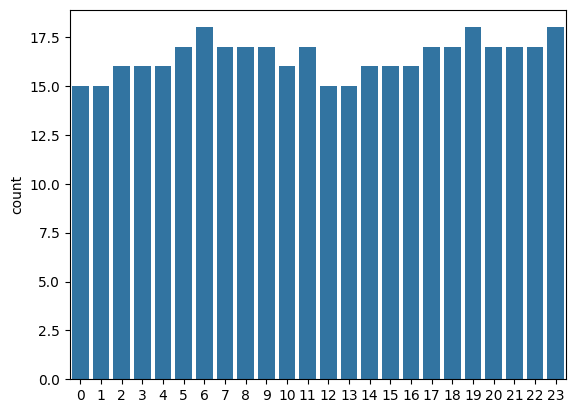

In [ ]:
from collections import Counter
import seaborn as sns
sns.countplot(x=y_test)
mapper = Counter(y_test)
mapper

In [ ]:
print(type(y))
print(type(y[0]))

<class 'list'>
<class 'int'>


In [ ]:
from torch.utils.data import Dataset
class ChromaDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    return self.X[idx].float(), torch.tensor(self.y[idx]).long()

  def __len__(self):
    return len(self.X)

In [ ]:
train_dataset = ChromaDataset(X_train, y_train)
test_dataset = ChromaDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Some Sanity Checks

Checking types

In [ ]:
x, y = train_dataset[0]
x.shape

torch.Size([1, 12, 302])

Checking ranges

Making sure `ChromaDataset` works

In [ ]:
dataset = ChromaDataset(X_train, y_train)
sample_x, sample_y = dataset[12]
print(sample_x.shape)

torch.Size([1, 12, 302])


Ensuring `DataLoader()` works

In [ ]:
loader = DataLoader(dataset, batch_size=4, shuffle=True)
xb, yb = next(iter(loader))
print(xb.shape)
print(yb.shape)

torch.Size([4, 1, 12, 302])
torch.Size([4])


Recovering chromagram from tensor

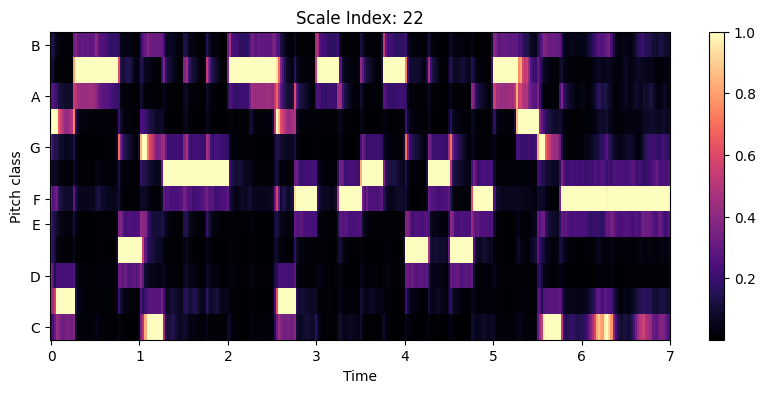

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

chroma = X_train[12].squeeze(0).numpy()  # [12, T]
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.title(f"Scale Index: {y_train[12]}")
plt.colorbar()
plt.show()

### Model Specifications

### Core Training Loop

In [ ]:
from tqdm import tqdm
def train_single_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in data_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = loss_fn(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    avg_loss = running_loss / len(data_loader)

    return avg_loss, train_acc

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    return correct / total

def train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        train_loss, train_acc = train_single_epoch(model, train_loader, loss_fn, optimizer, device)
        test_acc = evaluate(model, test_loader, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100 :.2f} %| Test Acc: {test_acc * 100:.2f} %")

        if epoch == epochs - 1:
          epochs_range = range(1, len(train_losses) + 1)

          plt.figure(figsize=(14, 5))

          # Accuracy plot
          plt.subplot(1, 2, 1)
          plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
          plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
          plt.title('Accuracy Over Epochs')
          plt.xlabel('Epoch')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.grid(True, alpha=0.3)

          # Loss plot
          plt.subplot(1, 2, 2)
          plt.plot(epochs_range, train_losses, label='Train Loss')
          plt.title('Training Loss Over Epochs')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.legend()
          plt.grid(True, alpha=0.3)

          plt.tight_layout()
          plt.show()
        print("-" * 70)


# Confusion Matrix and Some Model Metrics

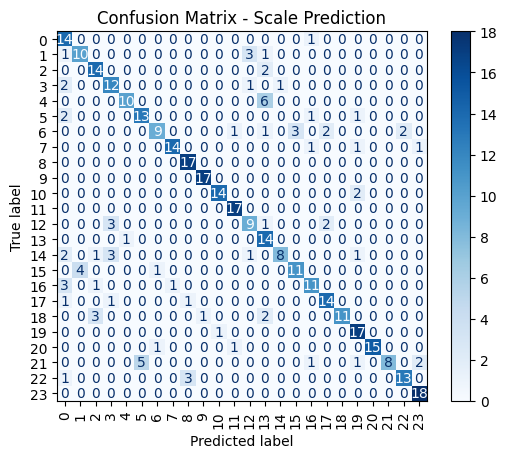

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        y_pred = model(x).argmax(dim=1)
        all_preds.extend(y_pred)
        all_labels.extend(y)

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix - Scale Prediction")
plt.show()

In [ ]:
import numpy as np
preds = np.array(all_preds)
labels = np.array(all_labels)

# How many times the model *predicted* class 3
pred_count = np.sum(preds == 23)

# How many of those were *actually* class 3
correct_count = np.sum((preds == 23) & (labels == 23))

print(f"Predicted class 16: {pred_count}")
print(f"Correctly predicted class 16: {correct_count}")

Predicted class 16: 21
Correctly predicted class 16: 18
